In [1]:
'''
introduction to the image data and format
'''
import os
import io
import pickle
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

# own stuff
import sys
sys.path.append('../src')
from stadium_def import lanes_new
from projection_util import project_lines
from mappings import pos_to_coco_lines, coco_line_colors
from unreal_util import draw_stadium, groundtruth_to_b
from anim_util import create_anim_from_array, animation

# location of data on disk
base_dir = '/disk2/data/UE5sim_3DHPE'
exp_dirs = os.listdir(base_dir)

print('available experiments:')
print(exp_dirs)

available experiments:
['ath0_jog', 'ath2_run_cam2', 'ath0_weirdarms', 'ath0_run', 'ath3_run', 'ath0_run_cam3', 'ath0_longstep', 'ath2_run', 'ath1_run_cam3', 'ath1_jog', 'ath0_fast_cam3', 'ath3_weirdarms', 'ath0_highknee', 'ath3_run_cam3', 'ath3_jog', 'ath1_highknee', 'ath2_fast_cam3']


In [2]:
# pick some experiment
exp = 'ath0_run'
exp_dir = os.path.join(base_dir, exp)

img_fold = os.path.join(exp_dir, 'MovieRenders')
img_pattern = os.path.join(img_fold, exp + '.%04d.jpeg')

groundtruth = pickle.load(open(os.path.join(exp_dir, 'groundtruth.pkl'), 'rb'))
N = len(groundtruth) - 1
print('image folder:', img_fold)
print('N =',N)
print('groundtruth keys:', list(groundtruth[0].keys()))

results = pickle.load(open(os.path.join(exp_dir, 'results_gt.pkl'), 'rb'))
print('results skeletons', results['skels'].keys())

image folder: /disk2/data/UE5sim_3DHPE/ath0_run/MovieRenders
N = 341
groundtruth keys: ['2d', '3d', 'projection', 'camrot', 'campos', 'fov']
results skeletons dict_keys(['gt', 'metrabs', 'metrabs_norot', 'lift3d'])


(920.0, -50.0)

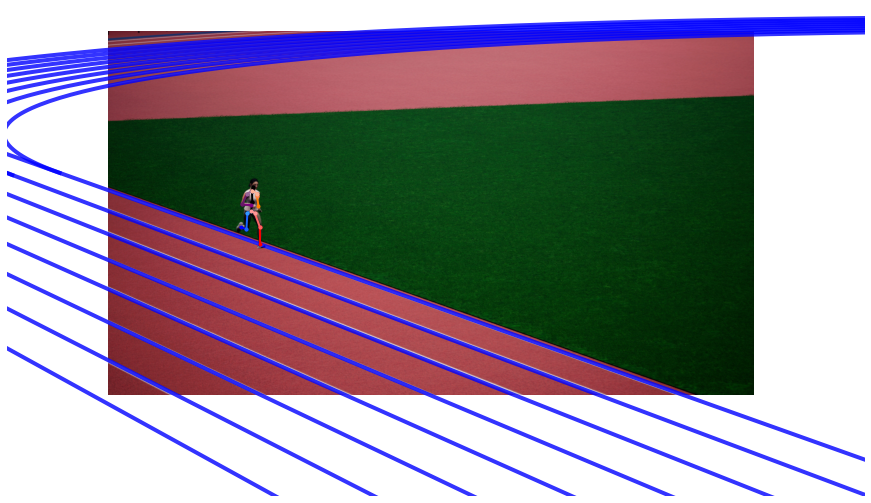

In [3]:
frame = 122

plt.figure(figsize=(16, 9))
ax = plt.subplot()

params = groundtruth[frame]['projection']
gt2d = groundtruth[frame]['2d']
gt3d = groundtruth[frame]['3d']

# project the 3d points into 2d using the current camera parameters
proj2d = project_lines(params, gt3d)

# draw lanes
for lanes in lanes_new:
    # reduce to only plot the frontal lines.
    proj_lines = project_lines(params, np.array(lanes[::2]))
    for line in proj_lines:
        ax.plot(*line.T, color='blue', linewidth=4, alpha=.8)

for j, l in enumerate(pos_to_coco_lines(proj2d)):
    plt.plot(*l.T, color=coco_line_colors[j], linewidth=2, marker='.')
        
img_path = img_pattern%(frame)
img = np.array(Image.open(img_path).convert('RGB'))
ax.imshow(img)
plt.axis('off')
ax.set_xlim(-200, 1500)
ax.set_ylim(920, -50)

  0%|          | 0/341 [00:00<?, ?it/s]


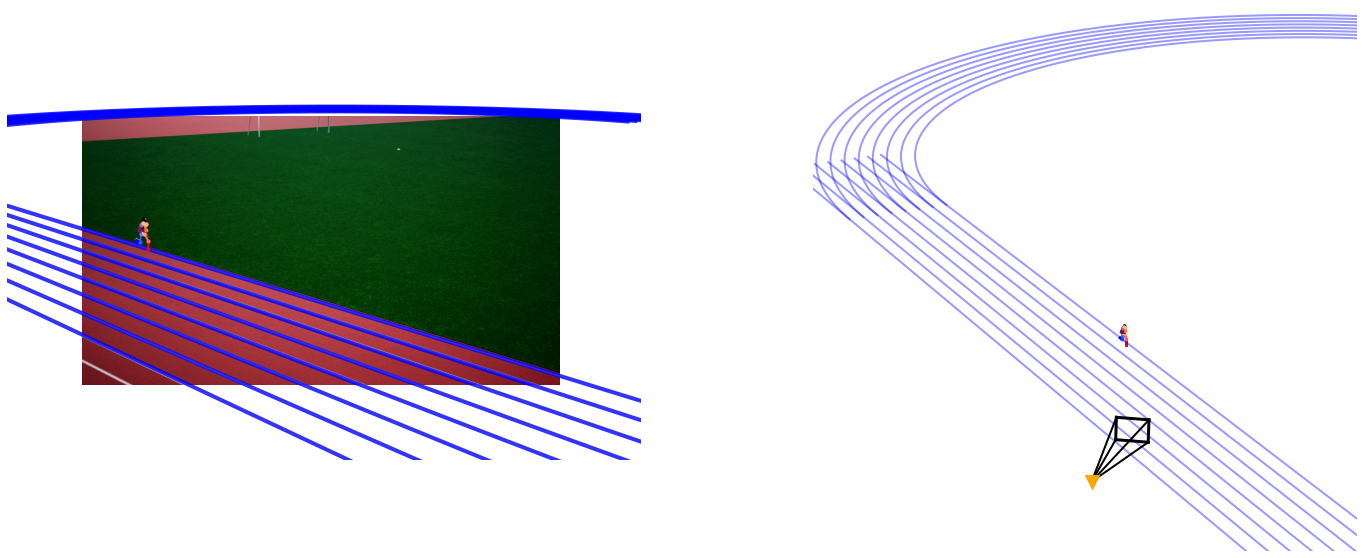

In [4]:
# render and store a video
view_correct = [-.1, 0, 0]

# switch to show single or render full video
single_frame = True
imgs = []
for frame in tqdm(range(N)):
    
    if single_frame:
        frame = 312
    
    fig = plt.figure(figsize=(25, 10))
    ax = plt.subplot(121)
    ax3d = plt.subplot(122, projection='3d')
    
    # ===
    # === grab data
    # ===
    params = groundtruth[frame]['projection']
    gt3d = groundtruth[frame]['3d'].copy()

    # ===
    # === plot 2d projection
    # ===
    # project the 3d points into 2d using the current camera parameters
    
    # background image
    img_path = img_pattern%(frame)
    img = np.array(Image.open(img_path).convert('RGB'))
    ax.imshow(img)
    
    # draw lanes
    for lanes in lanes_new:
        # reduce to only plot the frontal lines.
        proj_lines = project_lines(params, np.array(lanes[::2]))
        for line in proj_lines:
            ax.plot(*line.T, color='blue', linewidth=4, alpha=.8)
        
    # draw the skeleton 
    # for demonstration purposes: project the 3d data using the gt camera calibration
    proj2d = project_lines(params, gt3d)
    for j, l in enumerate(pos_to_coco_lines(proj2d)):
        ax.plot(*l.T, color=coco_line_colors[j], linewidth=2, marker='.')
    
    ax.set_xlim(-200, 1500)
    ax.set_ylim(920, -50)
    ax.axis('off')
    
    # ===
    # === plot 3d scene   
    # ===
    # skeleton
    for j, line in enumerate(pos_to_coco_lines(gt3d)):
        ax3d.plot3D(*line.T, color=coco_line_colors[j], linewidth=3)
    
    # draw the stadium lines
    draw_stadium(ax3d, alpha=.4)
    
    ax3d.set_xlim(15, 40)
    ax3d.set_ylim(-12, 13)
    ax3d.set_zlim(-5, 10)
    ax3d.axis('off')
    ax3d.view_init(20, -25)
    
    # plot the camera with exagerated F for better illustration
    b = groundtruth_to_b(groundtruth[frame])
    cam_pos = b['cam_pos']
    fake_F = 5
    view_dir = b['view_dir'] + view_correct
    ax3d.scatter(*cam_pos, s=200, color='orange', marker='v')
    image_plane = b['image_plane'] + view_dir*2
    for j, ip in enumerate(image_plane):
        ax3d.plot3D(*np.vstack((cam_pos, ip + (ip-cam_pos)*(fake_F-1))).T, linewidth=2, color='black')
        if j >= len(image_plane)-1:
            j = -1
        vec0 = cam_pos + (ip - cam_pos)*fake_F
        vec1 = cam_pos + (image_plane[j+1] - cam_pos)*fake_F
        ax3d.plot3D(*np.vstack((vec0, vec1)).T, linewidth=3, color='black')
    
    # ===
    # === show or render video
    # ===
    if single_frame:
        break
    
    # store image to buffer to render as a video later
    img_buf = io.BytesIO()
    fig.savefig(img_buf, format='jpg', dpi=200, bbox_inches='tight')

    im = np.array(Image.open(img_buf))[..., :3]
    imgs.append(im)
    plt.clf()
    plt.close()
    
if not single_frame:
    # store the video to disk
    anim = create_anim_from_array(imgs, figsize=(25, 10))

    from IPython.display import clear_output
    def callback_fun(i, n):
        print(f'\rSaving frame {i} of {n}',)
        clear_output(wait=True)

    writervideo = animation.FFMpegWriter(fps=30)
    anim_path = os.path.join(exp_dir, 'groundtruth_data.gif')
    anim.save(anim_path, writer=writervideo, progress_callback=callback_fun)

  0%|          | 0/341 [00:00<?, ?it/s]


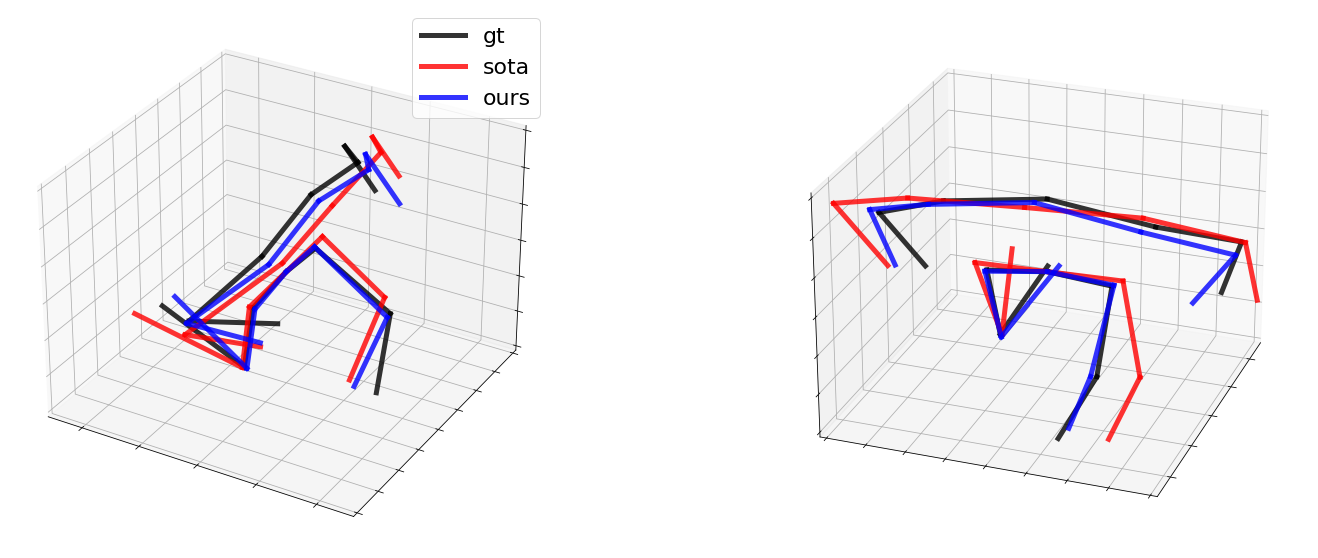

In [5]:
skip_idc = [3, 4, 5]

# switch to show single or render full video
single_frame = True
imgs = []
for frame in tqdm(range(N)):
    
    if single_frame:
        frame = 125
    
    fig = plt.figure(figsize=(25, 10))
    ax3d2 = plt.subplot(121, projection='3d')
    ax3d3 = plt.subplot(122, projection='3d')
    
    # ===
    # === compare skeletons
    # ===
    gt3d = groundtruth[frame]['3d'].copy()
    gt3d -= gt3d[0]
    for j, line in enumerate(pos_to_coco_lines(gt3d)):
        if j in skip_idc:
            continue
        ax3d2.plot3D(*line.T, color='black', linewidth=5, alpha=.8, label='gt' if j == 0 else None)
        ax3d3.plot3D(*line.T, color='black', linewidth=5, alpha=.8)
    
    metrabs3d = results['skels']['metrabs'][frame].copy()
    metrabs3d -= metrabs3d[0]
    for j, line in enumerate(pos_to_coco_lines(metrabs3d)):
        if j in skip_idc:
            continue
        ax3d2.plot3D(*line.T, color='red', linewidth=5, alpha=.8, label='sota' if j == 0 else None)
        ax3d3.plot3D(*line.T, color='red', linewidth=5, alpha=.8)
    
    lift3d = results['skels']['lift3d'][frame].copy()
    lift3d -= lift3d[0]
    for j, line in enumerate(pos_to_coco_lines(lift3d)):
        if j in skip_idc:
            continue
        ax3d2.plot3D(*line.T, color='blue', linewidth=5, alpha=.8, label='ours' if j == 0 else None)
        ax3d3.plot3D(*line.T, color='blue', linewidth=5, alpha=.8)
    
    # make uniform and nice
    ax3d2.set_xlim(-.5, .5)
    ax3d2.set_ylim(-.2, .2)
    ax3d2.set_zlim(-.6, .6)
    ax3d3.set_xlim(-.5, .5)
    ax3d3.set_ylim(-.2, .2)
    ax3d3.set_zlim(-.6, .6)
    ax3d2.set_xticklabels([])
    ax3d2.set_yticklabels([])
    ax3d2.set_zticklabels([])
    ax3d3.set_xticklabels([])
    ax3d3.set_yticklabels([])
    ax3d3.set_zticklabels([])
    ax3d3.view_init(25, 20)
    ax3d2.legend(fontsize=22, loc='upper right')
    
    # ===
    # === show or render video
    # ===
    if single_frame:
        break
    
    img_buf = io.BytesIO()
    fig.savefig(img_buf, format='jpg', dpi=200, bbox_inches='tight')

    im = np.array(Image.open(img_buf))[..., :3]
    imgs.append(im)
    plt.clf()
    plt.close()
    
if not single_frame:
    # store the video to disk
    anim = create_anim_from_array(imgs, figsize=(25, 10))

    from IPython.display import clear_output
    def callback_fun(i, n):
        print(f'\rSaving frame {i} of {n}',)
        clear_output(wait=True)

    writervideo = animation.FFMpegWriter(fps=30)
    anim_path = os.path.join(exp_dir, 'result_compare.gif')
    anim.save(anim_path, writer=writervideo, progress_callback=callback_fun)